<a href="https://colab.research.google.com/github/MrKeeplearning/dap-course/blob/main/final-project/seoul_apt_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,982 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 155222 files and d

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

In [2]:
# matplotlib의 폰트를 nanum폰트로 지정
plt.rc('font', family='NanumBarunGothic')

# 지난 5년간 서울 아파트 실거래가 분석

2021년 올 한 해 주요 이슈 중 하나가 부동산 가격 상승이라는 점에 동의하기 힘든 사람들은 적을 것이다. 집값 최상위권과 최하위권의 격차는 약 47배로 벌어졌고, 치솟는 집값에 무주택 가구 수도 지난해 처음으로 900만 가구를 넘었다고 한다.

그렇다면 서울에서 지난 5년간 아파트의 가격은 어떻게 변화하는 모습을 보였을까? 2016년 11월 30일부터 2021년 11월 30일까지 국토교통부 실거래가 공개시스템에서 제공하는 아파트 실거래가를 바탕으로 다양한 데이터를 확인해보려 한다.

In [3]:
df = pd.read_csv('/content/drive/MyDrive/dap_data/아파트(매매)__실거래가_total.csv', encoding='euc-kr')
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명,해제사유발생일,거래유형,중개사소재지
0,서울특별시 강남구 개포동,655-2,655.0,2.0,개포2차현대아파트(220),77.75,202104,15,"174,000",9,1988.0,언주로 103,NaN,-,-
1,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,54.98,202012,4,"146,000",1,1987.0,언주로 3,NaN,-,-
2,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202012,28,"155,400",3,1987.0,언주로 3,NaN,-,-
3,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202105,15,"195,000",5,1987.0,언주로 3,NaN,-,-
4,서울특별시 강남구 개포동,658-1,658.0,1.0,개포6차우성아파트1동~8동,79.97,202108,11,"200,000",3,1987.0,언주로 3,NaN,-,-


국통교통부 실거래가 공개시스템에서 제공하는 실거래가는 1년 단위로 밖에 다운로드하지 못하기 때문에 '아파트(매매)__실거래가_total.csv' 파일에 5년치 데이터를 모두 통합했다.

## Data Preprocessing

In [4]:
# 거래금액에 포함된 comma를 삭제하고 int형으로 전환
df['거래금액(만원)'] = df['거래금액(만원)'].str.replace(',', '').astype('int')

# 편의를 위해서 거래금액(만원)을 거래금액으로 이름을 변경한다.
df.rename(columns={'거래금액(만원)':'거래금액'}, inplace=True)

# 2014년 1월 1일부로 토지대장을 제외한 모든 곳에 도로명 주소만을 쓸 수 있게 되었기 때문에 번지와 번지의 구성요소인 본번과 부번은 삭제한다.
df = df.drop(['번지', '본번', '부번', '해제사유발생일', '거래유형', '중개사소재지'], axis=1)

# 시군구의 값을 시도, 시군구, 읍면동 형식으로 나누어준다.
df[['시도', '시군구', '읍면동']] = pd.DataFrame(df.시군구.str.split(' ', 3).tolist())

# 계약일 앞에 0이 붙지 않은 경우 0을 붙여준다.
df['계약일'] = df.계약일.map("{:02}".format)
# 계약년월과 계약일 합침
df['계약년월일'] = df[['계약년월', '계약일']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)
# 날짜 형식으로 변환
df['계약년월일'] = pd.to_datetime(df['계약년월일'])

# 중복된 데이터를 가지는 컬럼 삭제
df = df.drop(['계약년월', '계약일'], axis=1)
df.head()

,시군구,단지명,전용면적(㎡),거래금액,층,건축년도,도로명,시도,읍면동,계약년월일
0,강남구,개포2차현대아파트(220),77.75,174000,9,1988.0,언주로 103,서울특별시,개포동,2021-04-15
1,강남구,개포6차우성아파트1동~8동,54.98,146000,1,1987.0,언주로 3,서울특별시,개포동,2020-12-04
2,강남구,개포6차우성아파트1동~8동,79.97,155400,3,1987.0,언주로 3,서울특별시,개포동,2020-12-28
3,강남구,개포6차우성아파트1동~8동,79.97,195000,5,1987.0,언주로 3,서울특별시,개포동,2021-05-15
4,강남구,개포6차우성아파트1동~8동,79.97,200000,3,1987.0,언주로 3,서울특별시,개포동,2021-08-11


In [5]:
# 채워지지 않은 값이 있는지 확인해본다.
df.isnull().sum()

시군구        0
단지명        0
전용면적(㎡)    0
거래금액       0
층          0
건축년도       1
도로명        0
시도         0
읍면동        0
계약년월일      0
dtype: int64

In [6]:
df[df['건축년도'].isnull()]

,시군구,단지명,전용면적(㎡),거래금액,층,건축년도,도로명,시도,읍면동,계약년월일
30567,서초구,디에이치반포라클라스,84.9671,330000,25,NaN,서초중앙로 206,서울특별시,반포동,2021-11-05


In [7]:
# 전체 테이블 내에서 '디에이치반포라클라스'의 건축년도가 기입된 것이 있는지 확인해본다.
df[df.단지명 == '디에이치반포라클라스']

,시군구,단지명,전용면적(㎡),거래금액,층,건축년도,도로명,시도,읍면동,계약년월일
30567,서초구,디에이치반포라클라스,84.9671,330000,25,NaN,서초중앙로 206,서울특별시,반포동,2021-11-05


In [8]:
# 디에이치반포라클라스의 건축년도 하나만 NaN이고
# 전체 테이블 내에 단지명이 같은 row가 더 없기 때문에 해당 값을 직접 채워준다.
df.at[30567, '건축년도'] = 2021

In [9]:
df[df.단지명 == '디에이치반포라클라스']

,시군구,단지명,전용면적(㎡),거래금액,층,건축년도,도로명,시도,읍면동,계약년월일
30567,서초구,디에이치반포라클라스,84.9671,330000,25,2021.0,서초중앙로 206,서울특별시,반포동,2021-11-05


In [10]:
# 건축년도는 굳이 float형식으로 있을 필요가 없기 때문에 int형식으로 바꾸어준다.
df['건축년도'] = df['건축년도'].astype(int)
df.dtypes

시군구                object
단지명                object
전용면적(㎡)           float64
거래금액                int64
층                   int64
건축년도                int64
도로명                object
시도                 object
읍면동                object
계약년월일      datetime64[ns]
dtype: object

전용면적이 평이 아닌 제곱미터로 표현하는 것으로 지정되었지만 아직까지 평형이 좀 더 익숙하다. 따라서 제곱미터 형식으로 되어 있는 것을 평형으로 변환해준다. 1평은 3.305785㎡ 이기 때문에 기존 전용면적(㎡) 칼럼을 3.305785로 나누어준다. 또한 평당가격 칼럼도 생성한다.

In [11]:
df['전용면적(평)'] = df['전용면적(㎡)'] / 3.305785
df['평당가격'] = round(df['거래금액'] / df['전용면적(평)'].astype('int'), 2)
df.head()

,시군구,단지명,전용면적(㎡),거래금액,층,건축년도,도로명,시도,읍면동,계약년월일,전용면적(평),평당가격
0,강남구,개포2차현대아파트(220),77.75,174000,9,1988,언주로 103,서울특별시,개포동,2021-04-15,23.519376,7565.22
1,강남구,개포6차우성아파트1동~8동,54.98,146000,1,1987,언주로 3,서울특별시,개포동,2020-12-04,16.631451,9125.00
2,강남구,개포6차우성아파트1동~8동,79.97,155400,3,1987,언주로 3,서울특별시,개포동,2020-12-28,24.190926,6475.00
3,강남구,개포6차우성아파트1동~8동,79.97,195000,5,1987,언주로 3,서울특별시,개포동,2021-05-15,24.190926,8125.00
4,강남구,개포6차우성아파트1동~8동,79.97,200000,3,1987,언주로 3,서울특별시,개포동,2021-08-11,24.190926,8333.33


In [12]:
# 칼럼의 순서를 좀 더 정리된 모습으로 정렬한다.
df = df[['계약년월일', '건축년도', '시도', '시군구', '읍면동', '도로명', '단지명', '층', '거래금액', '전용면적(㎡)', '전용면적(평)', '평당가격']]
df.head()

,계약년월일,건축년도,시도,시군구,읍면동,도로명,단지명,층,거래금액,전용면적(㎡),전용면적(평),평당가격
0,2021-04-15,1988,서울특별시,강남구,개포동,언주로 103,개포2차현대아파트(220),9,174000,77.75,23.519376,7565.22
1,2020-12-04,1987,서울특별시,강남구,개포동,언주로 3,개포6차우성아파트1동~8동,1,146000,54.98,16.631451,9125.00
2,2020-12-28,1987,서울특별시,강남구,개포동,언주로 3,개포6차우성아파트1동~8동,3,155400,79.97,24.190926,6475.00
3,2021-05-15,1987,서울특별시,강남구,개포동,언주로 3,개포6차우성아파트1동~8동,5,195000,79.97,24.190926,8125.00
4,2021-08-11,1987,서울특별시,강남구,개포동,언주로 3,개포6차우성아파트1동~8동,3,200000,79.97,24.190926,8333.33


In [13]:
df.info

<bound method DataFrame.info of             계약년월일  건축년도     시도  시군구  ...    거래금액 전용면적(㎡)    전용면적(평)     평당가격
0      2021-04-15  1988  서울특별시  강남구  ...  174000   77.75  23.519376  7565.22
1      2020-12-04  1987  서울특별시  강남구  ...  146000   54.98  16.631451  9125.00
2      2020-12-28  1987  서울특별시  강남구  ...  155400   79.97  24.190926  6475.00
3      2021-05-15  1987  서울특별시  강남구  ...  195000   79.97  24.190926  8125.00
4      2021-08-11  1987  서울특별시  강남구  ...  200000   79.97  24.190926  8333.33
...           ...   ...    ...  ...  ...     ...     ...        ...      ...
392654 2017-05-29  2003  서울특별시  중랑구  ...   36900  125.09  37.839726   997.30
392655 2017-08-17  2003  서울특별시  중랑구  ...   19100   50.29  15.212726  1273.33
392656 2017-08-28  2003  서울특별시  중랑구  ...   30500   87.31  26.411276  1173.08
392657 2017-11-04  2003  서울특별시  중랑구  ...   25100   67.57  20.439926  1255.00
392658 2016-12-08  2007  서울특별시  중랑구  ...   32000   95.94  29.021851  1103.45

[392659 rows x 12 columns]>

📌 주요 칼럼 요약
* 거래금액 : 만원 단위
* 전용면적(평) : 전용면적(㎡) / 3.305785
* 평당가격 : 거래금액 / 전용면적(평)

📌 DataFrame 사이즈
* 392659 x 12 (rows x columns)

## 데이터 분석 및 시각화

### 실거래가 상하위 10위

In [14]:
df.sort_values('거래금액', ascending=False).head(10)

,계약년월일,건축년도,시도,시군구,읍면동,도로명,단지명,층,거래금액,전용면적(㎡),전용면적(평),평당가격
2946,2021-03-04,2020,서울특별시,강남구,청담동,압구정로79길 88,PH129,14,1150000,273.96,82.872903,14024.39
2945,2021-03-04,2020,서울특별시,강남구,청담동,압구정로79길 88,PH129,14,1150000,273.96,82.872903,14024.39
45241,2021-11-24,2020,서울특별시,용산구,한남동,유엔빌리지길 80-1,파르크한남,3,1150000,268.95,81.357378,14197.53
45240,2021-09-09,2020,서울특별시,용산구,한남동,유엔빌리지길 80-1,파르크한남,2,1080000,268.67,81.272678,13333.33
2947,2021-07-07,2020,서울특별시,강남구,청담동,압구정로79길 88,PH129,6,1000000,273.96,82.872903,12195.12
45239,2021-08-04,2020,서울특별시,용산구,한남동,유엔빌리지길 80-1,파르크한남,3,1000000,268.67,81.272678,12345.68
45216,2021-09-15,2019,서울특별시,용산구,한남동,한남대로10길 16,르가든더메인한남,6,970000,228.34,69.072853,14057.97
2948,2021-11-25,2020,서울특별시,강남구,청담동,압구정로79길 88,PH129,10,929070,273.96,82.872903,11330.12
2982,2021-05-10,2009,서울특별시,강남구,청담동,압구정로79길 72,상지리츠빌카일룸3차,19,850000,265.47,80.304678,10625.00
33653,2021-09-29,2011,서울특별시,성동구,성수동1가,서울숲2길 32-14,갤러리아포레,26,845000,241.93,73.183828,11575.34


In [15]:
df.sort_values('거래금액', ascending=True).head(10)

,계약년월일,건축년도,시도,시군구,읍면동,도로명,단지명,층,거래금액,전용면적(㎡),전용면적(평),평당가격
154303,2019-09-04,1995,서울특별시,구로구,구로동,도림로 12-10,성산E동,1,5400,21.90,6.624750,900.00
225670,2018-10-20,1997,서울특별시,구로구,구로동,도림로12길 5-7,(780-50),3,6000,21.81,6.597525,1000.00
72845,2020-06-10,1996,서울특별시,구로구,구로동,구로동로22길 70-9,(752-10),1,6000,25.53,7.722825,857.14
225638,2018-06-05,1995,서울특별시,구로구,구로동,구로동로22길 57,(742-57),1,6000,21.60,6.534000,1000.00
310879,2017-01-16,2013,서울특별시,강서구,화곡동,곰달래로20길 14,SRvill(925-3),7,6100,14.01,4.238025,1525.00
71066,2020-11-18,2002,서울특별시,구로구,개봉동,개봉로17나길 16,건양,1,6200,29.34,8.875350,775.00
310872,2017-01-16,2013,서울특별시,강서구,화곡동,곰달래로20길 14,SRvill(925-3),7,6300,14.22,4.301550,1575.00
310880,2017-01-16,2013,서울특별시,강서구,화곡동,곰달래로20길 14,SRvill(925-3),7,6300,14.22,4.301550,1575.00
310886,2017-01-16,2013,서울특별시,강서구,화곡동,곰달래로20길 14,SRvill(925-3),7,6300,14.22,4.301550,1575.00
310870,2017-01-16,2013,서울특별시,강서구,화곡동,곰달래로20길 14,SRvill(925-3),8,6300,14.22,4.301550,1575.00


실거래가 상위 10위는 흔히 떠올려 볼 수 있는 것처럼 주로 강남구 청담동과 용산구 한남동에 분포되어 있는 것을 확인할 수 있다. 한편 하위 10위는 주로 구로구 구로동과 강서구 화곡동에 분포되어 있다.

### 평당 가격 상하위 10위

In [16]:
df.sort_values('평당가격', ascending=False).head(10)

,계약년월일,건축년도,시도,시군구,읍면동,도로명,단지명,층,거래금액,전용면적(㎡),전용면적(평),평당가격
50330,2019-12-21,1982,서울특별시,강남구,개포동,개포로 310,개포주공1단지,5,250000,35.870,10.850675,25000.00
137073,2019-09-26,1982,서울특별시,강남구,개포동,개포로 310,개포주공1단지,1,240000,35.640,10.781100,24000.00
137056,2019-09-07,1982,서울특별시,강남구,개포동,개포로 310,개포주공1단지,1,210000,35.640,10.781100,21000.00
137024,2019-08-10,1982,서울특별시,강남구,개포동,개포로 310,개포주공1단지,2,200000,35.440,10.720600,20000.00
136995,2019-06-29,1982,서울특별시,강남구,개포동,개포로 310,개포주공1단지,5,199000,35.870,10.850675,19900.00
137088,2019-10-31,1982,서울특별시,강남구,개포동,개포로 310,개포주공1단지,3,196000,35.870,10.850675,19600.00
26360,2021-05-26,2021,서울특별시,동작구,상도동,상도로 164,드림캐슬타워,10,58418,11.819,3.575248,19472.67
26302,2021-05-26,2021,서울특별시,동작구,상도동,상도로 164,드림캐슬타워,13,58418,11.819,3.575248,19472.67
26336,2021-05-26,2021,서울특별시,동작구,상도동,상도로 164,드림캐슬타워,12,58418,11.819,3.575248,19472.67
26306,2021-05-26,2021,서울특별시,동작구,상도동,상도로 164,드림캐슬타워,17,58418,11.819,3.575248,19472.67


In [17]:
df.sort_values('평당가격', ascending=True).head(10)

,계약년월일,건축년도,시도,시군구,읍면동,도로명,단지명,층,거래금액,전용면적(㎡),전용면적(평),평당가격
350972,2017-01-09,1978,서울특별시,서대문구,연희동,증가로 61,시민,1,7000,57.69,17.451226,411.76
350973,2017-01-12,1978,서울특별시,서대문구,연희동,증가로 61,시민,1,8000,61.82,18.700551,444.44
284814,2018-02-06,2003,서울특별시,은평구,신사동,은평터널로13길 4,뉴월드(226-5),2,10000,69.86,21.132651,476.19
133218,2020-10-12,2001,서울특별시,중구,신당동,동호로11마길 20-7,인성아트빌,-1,8300,58.11,17.578276,488.24
323704,2017-03-13,2002,서울특별시,금천구,시흥동,시흥대로14길 29,백운스위트빌,2,9800,64.00,19.360001,515.79
89071,2020-10-23,2000,서울특별시,도봉구,쌍문동,우이천로30길 43,로얄,-1,6500,42.00,12.705000,541.67
157083,2019-03-06,1975,서울특별시,금천구,시흥동,독산로24나길 13,시흥(817-29),5,6500,39.83,12.048575,541.67
74403,2020-02-29,1994,서울특별시,구로구,구로동,구로동로12길 45,청우아트빌라3차,1,7000,42.30,12.795750,583.33
153787,2019-03-14,1996,서울특별시,구로구,구로동,구로동로22길 54,(743-6),3,7000,41.35,12.508375,583.33
60628,2020-05-20,1975,서울특별시,강북구,수유동,덕릉로 12,화계맨숀,5,10000,58.51,17.699276,588.24


지난 5년간 평당 가격 상위 10위에는 개포주공1단지가 6개의 row를 차지하는 것을 볼 수 있는데 이것은 개포주공1단지가 디에이치퍼스티어아이파크로 재건축됨에 따라 높은 평당가격을 보인 것으로 보인다. 한편, 하위 10위에는 특정 지역에 집중되어 있지는 않고 다양하게 분포되어 있는 모습을 보인다.

### 연도별 아파트 거래량

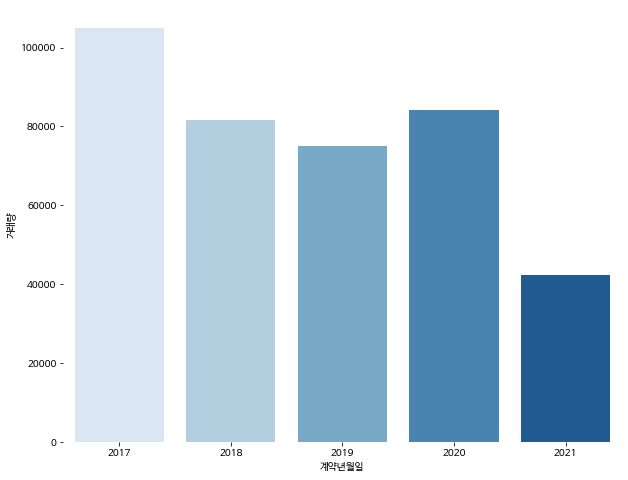

In [18]:
condition = (df['계약년월일'].dt.year >= 2017) & (df['계약년월일'].dt.year <= 2021)
df_contract_1721 = df.loc[condition]
plt.figure(figsize = (10,8))
plt.box(False)
ax = sns.countplot(x=df_contract_1721['계약년월일'].dt.year,
                   data=df_contract_1721,
                   palette='Blues')
ax.set(ylabel='거래량')
plt.show()

2017년 이후로 2018년과 2019까지는 아파트 거래량이 감소하는 추세를 보였으나 2020년에는 2018년과 비슷한 추세로 아파트 거래량이 증가한 것을 확인할 수 있다. 그리고 다시 2021년에는 아파트 거래량이 대폭 감소한 것을 확인할 수 있다.

현재 사용한 데이터가 2016년 11월 30일부터 수집한 데이터이고, 16년도 데이터는 연도별 변화 추이를 확인하기에는 적합하지 않기 때문에 제외했다.

### 지난 5년간 어떤 구에서 아파트를 가장 많이 거래했을까?

In [19]:
#편의를 위해 연 칼럼을 하나 더 생성한다.
df['연'] = df['계약년월일'].dt.year

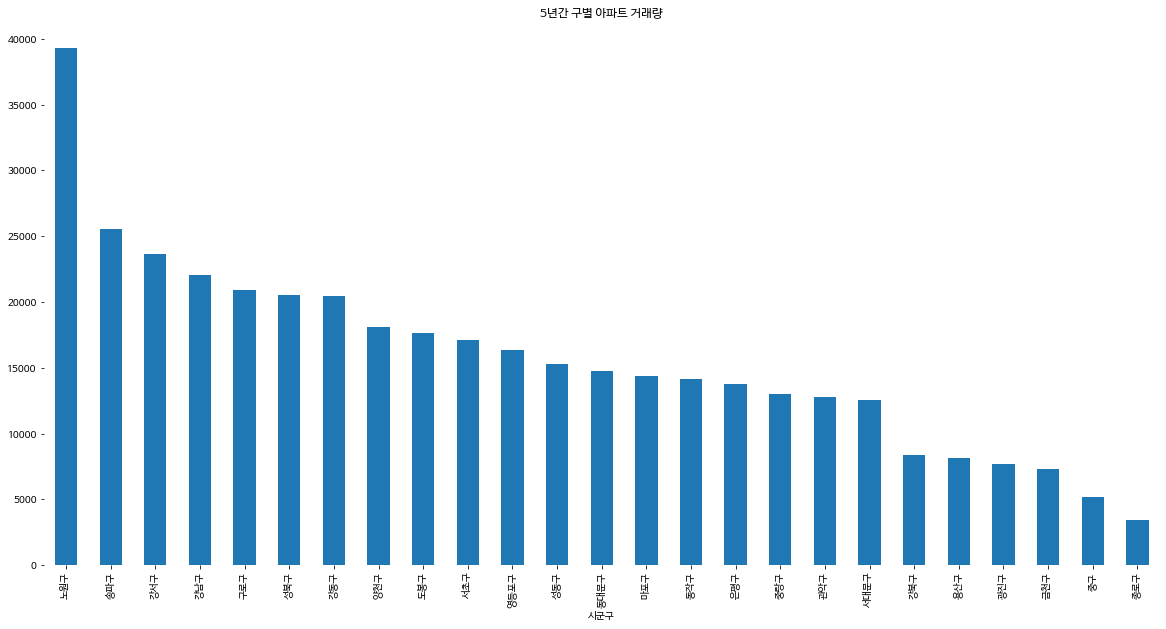

In [20]:
df.value_counts('시군구').plot(kind='bar', figsize=(20, 10)).set_title('5년간 구별 아파트 거래량')
plt.box(False)
plt.show()

### 노원구의 각 구 별 거래금액, 평수, 층 분포

노원구의 거래량이 가장 압도적으로 많은데, 어떤 특징이 있는지 확인해보려 한다.

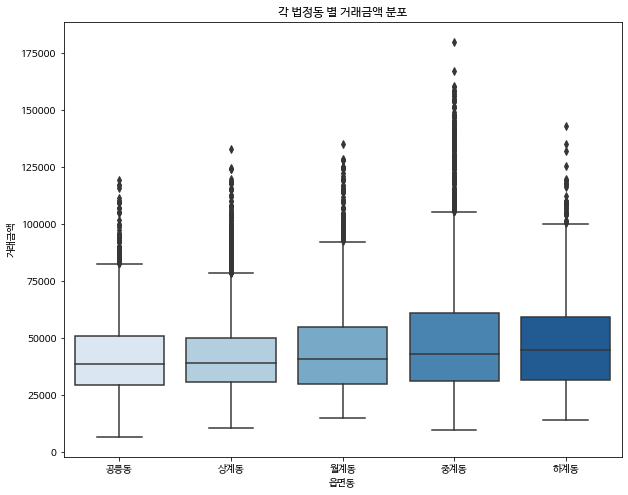

In [21]:
condition = (df['시군구']=='노원구')
df_nowongu = df.loc[condition]
df_nowongu

fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x='읍면동', y='거래금액', data=df_nowongu, palette='Blues')
plt.title("각 법정동 별 거래금액 분포")
plt.show()

이상치를 탐색해본다.

In [22]:
df_nowongu[df_nowongu['거래금액']>150000]

,계약년월일,건축년도,시도,시군구,읍면동,도로명,단지명,층,거래금액,전용면적(㎡),전용면적(평),평당가격,연
19898,2021-05-01,1993,서울특별시,노원구,중계동,한글비석로8길 20,대림벽산(363),12,154000,141.45,42.788627,3666.67,2021
19920,2021-06-19,1993,서울특별시,노원구,중계동,중계로 184,라이프,6,153500,115.65,34.984126,4514.71,2021
19921,2021-08-05,1993,서울특별시,노원구,중계동,중계로 184,라이프,6,154700,115.65,34.984126,4550.00,2021
19923,2021-08-11,1993,서울특별시,노원구,중계동,중계로 184,라이프,6,158500,115.65,34.984126,4661.76,2021
19924,2021-10-29,1993,서울특별시,노원구,중계동,중계로 184,라이프,12,151000,115.65,34.984126,4441.18,2021
19925,2021-11-08,1993,서울특별시,노원구,중계동,중계로 184,라이프,14,154000,115.65,34.984126,4529.41,2021
19962,2021-11-20,1993,서울특별시,노원구,중계동,노원로22길 34,롯데우성아파트,11,152000,115.26,34.866151,4470.59,2021
20038,2021-08-05,1993,서울특별시,노원구,중계동,중계로 184,신동아(366),14,156000,115.35,34.893376,4588.24,2021
20040,2021-08-25,1993,서울특별시,노원구,중계동,중계로 184,신동아(366),10,156000,115.35,34.893376,4588.24,2021
20057,2021-03-02,1993,서울특별시,노원구,중계동,중계로 195,신안동진,7,160000,134.74,40.758852,4000.00,2021


가장 많이 등장한 '신안동진'아파트와 '라이프'아파트의 가격변화 추이를 확인해본다.

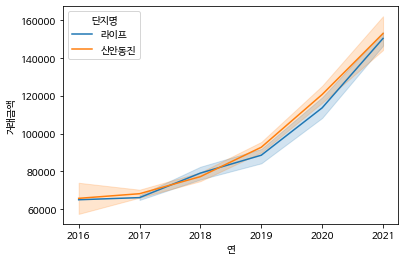

In [23]:
df_price_change = df_nowongu[(df_nowongu.단지명 == '신안동진') | (df_nowongu.단지명 == '라이프')]

sns.lineplot(x='연',
             y='거래금액',
             hue='단지명',
             data = df_price_change);

두 개의 단지 모두 5년간 약 10억원 가까이 가격이 상승한 것을 볼 수 있다.

이번에는 노원구에서 각 법정동 별로 어떤 평수와 층이 거래되었는지 그 분포를 확인해본다.

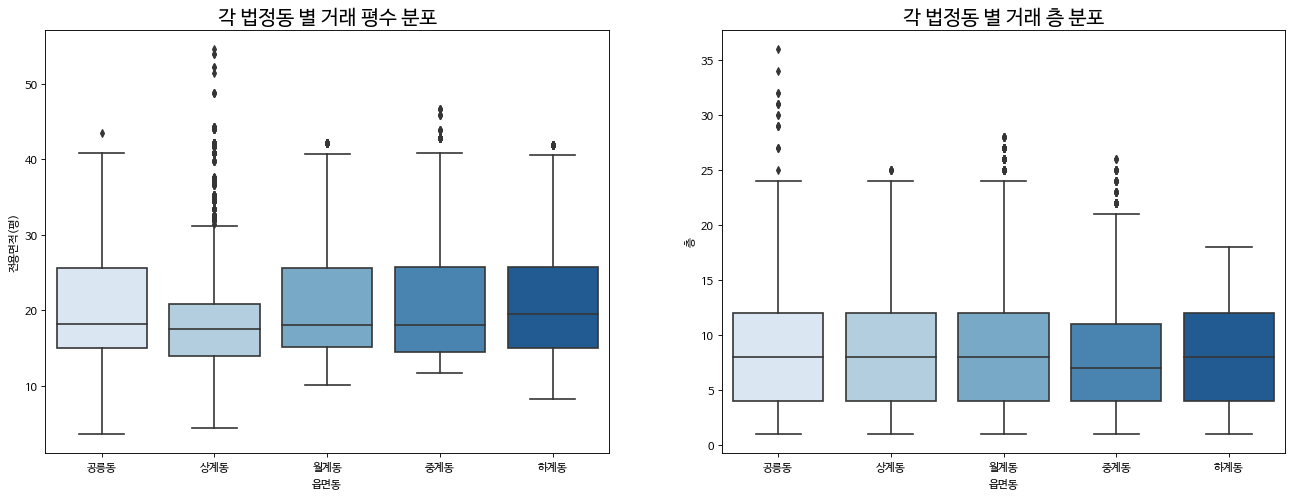

In [24]:
condition = (df['시군구']=='노원구')
df_nowongu = df[condition]

fig, axes = plt.subplots(1,2, figsize=(20,7), dpi=80)
sns.boxplot(x='읍면동', y='전용면적(평)', data=df_nowongu, ax=axes[0], palette='Blues')
sns.boxplot(x='읍면동', y='층', data=df_nowongu, ax=axes[1], palette='Blues')

axes[0].set_title('각 법정동 별 거래 평수 분포', fontsize=18)
axes[1].set_title('각 법정동 별 거래 층 분포', fontsize=18)
plt.show()

## Reference

* 데이터: [국토교통부 실거래가 공개시스템](http://rtdown.molit.go.kr/)
* https://baem1n.dev/2021/01/30/DATA-APT-04/